# The Translator With Transformer Architecture

# Library

In [1]:
# Commented out IPython magic to ensure Python compatibility.
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
# %apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# %pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
# %pip install protobuf~=3.20.3
# %pip install -q tensorflow_datasets
# %pip install -q -U tensorflow-text tensorflow

import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_text
from pickle import load, dump

In [12]:
print(tf.__version__)

2.10.1


# Load Tokenizer

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit this guide.

This tutorial uses the tokenizers built in the subword tokenizer tutorial. That tutorial optimizes two text.BertTokenizer objects (one for English, one for Portuguese) for this dataset and exports them in a TensorFlow saved_model format.


In [8]:
# if 0:
#   model_name = 'ted_hrlr_translate_pt_en_converter'
#   tf.keras.utils.get_file(
#       f'{model_name}.zip',
#       f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
#       cache_dir='.', cache_subdir='', extract=True
#   )
#   tokenizers = tf.saved_model.load(model_name)
model_name = './metadata/tokenizer_deu_eng'
tokenizers = tf.saved_model.load(model_name)

print( type(tokenizers) )
print( type(tokenizers.eng) )

<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>
<class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


In [11]:
en_examples = ['Hello TensorFlow!']

tokens = tokenizers.eng.tokenize(en_examples)
print(tokens)
texted_tokens = tokenizers.eng.lookup(tokens)
print(texted_tokens)
encoded = tokenizers.eng.detokenize(tokens)
print(encoded)
print(encoded.numpy()[0].decode('utf-8'))

<tf.RaggedTensor [[2, 1871, 513, 116, 943, 2433, 1185, 4593, 4, 3]]>
<tf.RaggedTensor [[b'[START]', b'hello', b'ten', b'##s', b'##or', b'##f', b'##l', b'##ow',
  b'!', b'[END]']]>
tf.Tensor([b'hello tensorflow !'], shape=(1,), dtype=string)
hello tensorflow !


# Load dataset

In [15]:
filename = '../data/deu-eng-train.pkl'
with open( filename, 'rb') as file:
    train_data = load(file)
for i, pair in enumerate(train_data):
  if i == 2: break
  print(pair[0].decode('utf-8'))
  print(pair[1])
  print('\n')    

train_data2 = np.array(train_data)
trainX = train_data2[:, 0]
trainY = train_data2[:, 1]
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))

filename = '../data/deu-eng-val.pkl'
with open( filename, 'rb') as file:
    val_data = load(file)
val_data2 = np.array(val_data)
valX = val_data2[:, 0]
valY = val_data2[:, 1]
val_dataset = tf.data.Dataset.from_tensor_slices((valX, valY))

Tom zahlt ein Bußgeld.
b'Tom is paying a fine.'


Unter dem Bett ist eine Katze.
b'There is a cat under the bed.'




# Tokenize Dataset Prepare Batch Dataset

In [16]:
MAX_TOKENS=128
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [18]:
def prepare_batch(deu, eng):
    deu = tokenizers.deu.tokenize(deu)      # Output is ragged.
    deu = deu[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    deu = deu.to_tensor()  # Convert to 0-padded dense Tensor

    eng = tokenizers.eng.tokenize(eng)
    eng = eng[:, :(MAX_TOKENS+1)]
    eng_inputs = eng[:, :-1].to_tensor()  # Drop the [END] tokens
    eng_labels = eng[:, 1:].to_tensor()   # Drop the [START] tokens

    return (deu, eng_inputs), eng_labels

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

In [20]:
"""It appears that train_batches.take(1) will return shuffled batches. So the results differ."""
for (deu, eng), eng_labels in train_batches.take(1):
  break

print(deu.shape)
print(eng.shape)
print(eng_labels.shape)
print(eng[0][:10])
print(eng_labels[0][:10])

(32, 40)
(32, 26)
(32, 26)
tf.Tensor([  2  64 974  95  65  75 245  68  14   0], shape=(10,), dtype=int64)
tf.Tensor([ 64 974  95  65  75 245  68  14   3   0], shape=(10,), dtype=int64)


# Position Encoding

In [23]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
# plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
# plt.ylabel('Depth')
# plt.xlabel('Position')
# plt.colorbar()
# plt.show()

# pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
# p = pos_encoding[1000]
# dots = tf.einsum('pd,d -> p', pos_encoding, p)
# plt.subplot(2,1,1)
# plt.plot(dots)
# plt.ylim([0,1])
# plt.plot([950, 950, float('nan'), 1050, 1050],
#          [0,1,float('nan'),0,1], color='k', label='Zoom')
# plt.legend()
# plt.subplot(2,1,2)
# plt.plot(dots)
# plt.xlim([950, 1050])
# plt.ylim([0,1])

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

embed_deu = PositionalEmbedding(vocab_size=tokenizers.deu.get_vocab_size(), d_model=512)
embed_eng = PositionalEmbedding(vocab_size=tokenizers.eng.get_vocab_size(), d_model=512)

deu_emb = embed_deu(deu)
eng_emb = embed_eng(eng)

print(deu_emb.shape)
print(eng_emb.shape)

# eng_emb._keras_mask


(2048, 512)
(32, 40, 512)
(32, 26, 512)


# Attention

RNNs and CNNs have their limitations.

* The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
* In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers, You need to stack a number of Convolution layers to transmit information across the sequence (Wavenet reduces this problem by using dilated convolutions).


In [29]:
"""## Base Attention"""
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

"""## Cross Attention"""

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
                                        query=x,
                                        key=context,
                                        value=context,
                                        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

"""The output length of CrossAttention is the length of the query sequence, and not the length of the context key/value sequence."""

sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(deu_emb.shape)
print(eng_emb.shape)
print(sample_ca(eng_emb, deu_emb).shape)

"""## Global Self Attention"""

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
                          query=x,
                          value=x,
                          key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(deu_emb.shape)
print(sample_gsa(deu_emb).shape)

"""# Causal Attention

Like the text generation tutorial, and the NMT with attention tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".
"""

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
                          query=x,
                          value=x,
                          key=x,
                          use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(eng_emb.shape)
print(sample_csa(eng_emb).shape)

"""This seems to be an important check. Can do this check in the Mastery version"""

out1 = sample_csa(embed_eng(eng[:, :3]))
out2 = sample_csa(embed_eng(eng))[:, :3]

print(out1.shape)
tf.reduce_max(abs(out1 - out2)).numpy()

out1 = sample_gsa(embed_eng(eng[:, :3]))
out2 = sample_gsa(embed_eng(eng))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()


(32, 40, 512)
(32, 26, 512)
(32, 26, 512)
(32, 40, 512)
(32, 40, 512)
(32, 26, 512)
(32, 26, 512)
(32, 3, 512)


0.1343607

# Feedforward Network

In [31]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

sample_ffn = FeedForward(512, 2048)

print(eng_emb.shape)
print(sample_ffn(eng_emb).shape)


(32, 26, 512)
(32, 26, 512)


# Encoder

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(deu_emb.shape)
print(sample_encoder_layer(deu_emb).shape)

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(deu, training=False)

# Print the shape.
print(deu.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(32, 40, 512)
(32, 40, 512)
(32, 40)
(32, 40, 512)


# Decoder

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=eng_emb, context=deu_emb)

print(eng_emb.shape)
print(deu_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=eng,
    context=deu_emb)

# Print the shapes.
print(eng.shape)
print(deu_emb.shape)
print(output.shape)

sample_decoder.last_attn_scores.shape

(32, 26, 512)
(32, 40, 512)
(32, 26, 512)
(32, 26)
(32, 40, 512)
(32, 26, 512)


TensorShape([32, 8, 26, 40])

# Transformer

In [36]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [38]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

# Test


In [40]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.deu.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.eng.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

output = transformer((deu, eng))

print(eng.shape)
print(deu.shape)
print(output.shape)

(32, 26)
(32, 40)
(32, 26, 5518)


**See the head actually multiplies the input matrix. Because it acutally duplicates the matrix. But in Mastery it reshapes the input matrix which is wierd.** <br>
**In the Mastery earlier introduction to multi-head attention it say it duplicates the matricies by number of header does the same scaled dot product attention. And then concate the #heads and go through a dense to combine them.** <br>

In [42]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(32, 8, 26, 40)


In [43]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3653888   
                                                                 
 decoder_2 (Decoder)         multiple                  5456128   
                                                                 
 dense_50 (Dense)            multiple                  711822    
                                                                 
Total params: 9,821,838
Trainable params: 9,821,838
Non-trainable params: 0
_________________________________________________________________


# Optimizer - Customized Scheduler

Text(0.5, 0, 'Train Step')

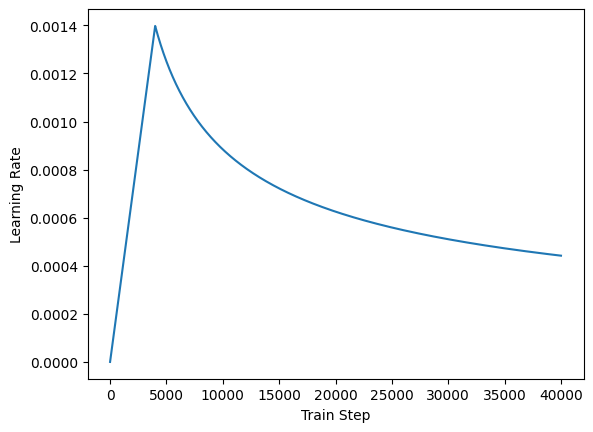

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# Loss and Metrics

In [46]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


# Compile and Fit

In [47]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
6538/6538 [==============================] - 256s 38ms/step - loss: 2.8807 - masked_accuracy: 0.5489 - val_loss: 1.7518 - val_masked_accuracy: 0.6868
Epoch 2/20
6538/6538 [==============================] - 284s 43ms/step - loss: 1.6256 - masked_accuracy: 0.7045 - val_loss: 1.4188 - val_masked_accuracy: 0.7387
Epoch 3/20
6538/6538 [==============================] - 266s 41ms/step - loss: 1.3909 - masked_accuracy: 0.7413 - val_loss: 1.2938 - val_masked_accuracy: 0.7597
Epoch 4/20
6538/6538 [==============================] - 270s 41ms/step - loss: 1.2732 - masked_accuracy: 0.7602 - val_loss: 1.2251 - val_masked_accuracy: 0.7712
Epoch 5/20
6538/6538 [==============================] - 269s 41ms/step - loss: 1.1965 - masked_accuracy: 0.7733 - val_loss: 1.1778 - val_masked_accuracy: 0.7802
Epoch 6/20
6538/6538 [==============================] - 270s 41ms/step - loss: 1.1403 - masked_accuracy: 0.7829 - val_loss: 1.1528 - val_masked_accuracy: 0.7847
Epoch 7/20
6538/6538 [============

# Inference

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.deu.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.eng.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.eng.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.eng.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [ ]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
translator = Translator(tokenizers, transformer)

sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)


# Export the model

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
        tokens,
        attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

        return result, tokens, attention_weights

translator = ExportTranslator(translator)
tf.saved_model.save(translator, export_dir='./metadata/translator_5')

result, _, _ = translator('este é o primeiro livro que eu fiz.')
print(result.numpy())


reloaded = tf.saved_model.load('./Bootcamp/Tranformer_TF/metadata/translator_5')
result, _, _ = reloaded('este é o primeiro livro que eu fiz.')

# Attention Plots

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)
#   plt.show()

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape


in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.deu.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.deu.lookup(in_tokens)[0]
print(in_tokens)

print(translated_tokens)


plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.deu.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.deu.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])


sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])
